## Random Data Challenge  
Part 1) Find an interesting dataset in the wild and convert it to an SQL-like database.  Pick something large enough to be challenging, but not so large as to require cloud resources. 

Part 2) Propose and answer three questions that exemplify typical Exploratory Data Analysis.



### Part 1  
I've chosen bird watching data from https://feederwatch.org/explore/raw-dataset-requests/.  Personally, I have no interest in birds and couldn't tell a penguin from a peregrine and have never looked at any bird-related data before.  Thus, I figured this dataset actually presents a legitimate challenge.  

The data chosen consisted of:  
1) "checklist data" from https://clo-pfw-prod.s3-us-west-2.amazonaws.com/data/PFW_2016_2020_public.csv which contains ~9.2 million rows each consisting of an observation of a given species (or species grouping), how many of a given species were observed, location data of the observation, and various metadata about the observation.  This file contains data for observations observed at bird feeding stations from 2016-2020.  
2) "location data" from https://clo-pfw-prod.s3.us-west-2.amazonaws.com/data/PFW_count_site_data_public_2021.csv which contains data on the local environment, ecological features, and bird feeders for all sites involved in the project.  
3) An excel sheet with definitions for column labels and species codes found in the above: https://drive.google.com/file/d/1kHmx2XhA2MJtEyTNMpwqTQEnoa9M7Il2/view?usp=sharing  

For simplicity, I've chosen to convert these data to an SQLITE database containing two tables.  The "feeding" table contains all checklist (observation) data while "sites" contains all location data.

The python file below processes downloaded .csv files  



```
__author__ = "Paul Smith"
__copyright__ = "None"
__email__ = "***"
__status__ = "Demo"

import os,sys
from typing import List,Tuple
import re
import logging
import sqlite3

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

"""
Module for reading bird observation data downloaded from https://feederwatch.org/explore/raw-dataset-requests/

Local CSV files are converted to a local sqlite3 db with two tables:
   feeding: data from a "checklist" file on species of birds observed, when, where, etc.
   sites: data about a particular observation site (local ecology etc.)

USAGE
-----
python3 ingest.py path_to_feeder.csv path_to_sites.csv [output.db]

path_to_feeder.csv = path to csv containing data for "feeding" table
path_to_sites.csv = path to csv containing location/site data
output.db [optional] = output for local sqlite3 file (defaults to "bird_data.db")

"""

def read_csv(path: str) -> Tuple[list,list]:
    """
    Generic CSV reader for files with a header row

    Reads and parses a csv file, returns a header row (list) and a nested list
    of data rows.  Each line of csv is parsed by regex which ignores quoted 
    commas.  Python's csv.reader() likely handles nested quotations an more complex
    examples better and pandas.read_csv is undoubtedly better faster.  However,
    if you had to just bare Python, this function will get the job done.

    Parameters
    ----------
    path: str
       string indicating path to local csv file (should be validated upstream)

    Returns
    -------
    header: List[str]
        list of strings corresponding to column labels
    data_rows: List[list]
        list of lists with each inner list corresponding to a single row of data
        
    Notes
    -----
    * Only rows with the same number of fields as the header row are output.  Logging
      messages indicate if any malformatted rows exist
    """
    all_lines = []
    quoted_splitter = re.compile(r',(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)')
    with open(path,'r') as f:
        for line in f.readlines():
            as_fields = list(field.strip() for field in quoted_splitter.split(line))
            all_lines.append(as_fields)
    # split into header and data
    header = list(str(field) for field in all_lines[0])
    data_rows = all_lines[1::]
    # remove malformatted data rows
    n_cols = len(header)
    mismatched = list(i for i,row in enumerate(data_rows) if len(row) != n_cols)
    if mismatched:
        logger.warning("Malformatted data rows {} not extracted".format(str(mismatched)))
        to_remove = sorted(mismatched,reverse=True)
        for index in to_remove:
            del data_rows[index]
    logger.debug("Extracted {} rows from {}".format(len(data_rows),path))
    return header,data_rows


def create_db(feed_data: List[tuple],
              feed_cols: List[str],
              site_data: List[tuple],
              site_cols: List[str],
              db_path: str) -> None:
    """
    Creates a local sqlite3 db with feeding and sites tables created from
    input data lists.

    Parameters
    ----------
    feed_data: List[tuple]
        data for feed table as list of iterables
    feed_cols: List[str]
        list of column names for feeding table
    site_data: List[tuple]
        data for site table as list of iterables
    site_cols: List[str]
        list of column names for sites table
    db_path: str
        path for output sqlite3 local file

    Notes
    -----
    * Each pair of data and cols must be "aligned" in that each element in
      feed_data much have length equal to feed_cols etc.
    * All datatypes/affinities are "BLOB" and should be processed 
      downstream

    """
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS feeding")
    cur.execute("DROP TABLE IF EXISTS sites")
    cur.execute("CREATE TABLE feeding ({})".format(",".join(feed_cols)))
    cur.execute("CREATE TABLE sites ({})".format(",".join(site_cols)))
    sql = "INSERT INTO feeding VALUES({});".format(",".join(list("?" for col in feed_cols)))
    cur.executemany(sql,feed_data)
    n_rows = cur.execute("SELECT COUNT() FROM feeding").fetchone()[0]
    logger.debug("Inserted {} rows into 'feeding' table".format(n_rows))
    sql = "INSERT INTO sites VALUES({});".format(",".join(list("?" for col in site_cols)))
    cur.executemany(sql,site_data)
    conn.commit()
    conn.close()


def ingest(feeder_path: str,
           site_path: str,
           db_path: str) -> None:
    """
    Wrapper function that reads comman line args, extracts data from csv files,
    and directs db creation.

    Parameters
    ----------
    feeder_path: str
        descriptor for path to csv containing checklist/observation data
    site_path: str
        descriptor for path to csv containing site data
    db_path: str
        descriptor for output path for created sqlite3 database

    """
    feed_cols,feed_data = read_csv(feeder_path)
    site_cols,site_data = read_csv(site_path)
    create_db(feed_data,feed_cols,site_data,site_cols,db_path)
    

if __name__ == "__main__":
    # setup logging for command line output to stderr
    handler = logging.StreamHandler(sys.stderr)
    handler.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(name)s:%(lineno)d - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    # sanity check input
    if len(sys.argv) < 3:
        logger.warning("Must input at least 2 path descriptors")
        sys.exit()
    feeder_path = sys.argv[1]
    site_path = sys.argv[2]
    if len(sys.argv) > 3:
        db_path = sys.argv[3]
    else:
        db_path = "bird_data.db"
    for pname,path in (("feeder",feeder_path),("site",site_path)):
        if not os.path.exists(path):
            logger.warning("Path for {} data '{}' does not exist!  Aborting".format(pname,path))
            sys.exit()
    # run ingest
    ingest(feeder_path,site_path,db_path)
```       


### database setup / tweaks  
The database created by the above is entirely unnormalized and all data columns are of type "BLOB".  In the "feeding" table, the LOC_ID column and LATITUDE/LONGITUDE are functionally dependent, as is SUBNATIONAL1_CODE.  There is also some dependency between the PROJ_PERIOD_ID and date related columns.  However, I've left these tables as is but note that some normalization could be done to streamline this table.  The following script converts each column to a proper datatype and adds an index on the location identifier key columns.

```
.open bird_data.db

BEGIN TRANSACTION;

ALTER TABLE feeding RENAME TO _feeding;

CREATE TABLE feeding (LOC_ID TEXT,
       	             LATITUDE REAL,
		     LONGITUDE REAL,
    		     SUBNATIONAL1_CODE TEXT,
    		     ENTRY_TECHNIQUE TEXT,
    		     SUB_ID TEXT,
    		     OBS_ID TEXT,
    		     Month INT,
    		     Day INT,
    		     Year INT,
    		     PROJ_PERIOD_ID TEXT,
    		     SPECIES_CODE TEXT,
    		     HOW_MANY INT,
    		     PLUS_CODE TEXT,
    		     VALID INT,
    		     REVIEWED INT,
    		     DAY1_AM INT,
    		     DAY1_PM INT,
    		     DAY2_AM INT,
    		     DAY2_PM INT,
    		     EFFORT_HRS_ATLEAST REAL,
    		     SNOW_DEP_ATLEAST REAL,
    		     Data_Entry_Method TEXT);

INSERT INTO feeding SELECT * FROM _feeding;

CREATE INDEX loc_species ON feeding (LOC_ID,SPECIES_CODE);

ALTER TABLE sites RENAME TO _sites;

CREATE TABLE sites (loc_id TEXT,
                    proj_period_id TEXT,
		    yard_type_pavement INT,
		    yard_type_garden INT,
		    yard_type_landsca INT,
		    yard_type_woods INT,
		    yard_type_desert INT,
		    hab_dcid_woods INT,
		    hab_evgr_woods INT,
		    hab_mixed_woods INT,
		    hab_orchard INT,
		    hab_park INT,
		    hab_water_fresh INT,
		    hab_water_salt INT,
		    hab_residential INT,
		    hab_industrial INT,
		    hab_agricultural INT,
		    hab_desert_scrub INT,
		    hab_young_woods INT,
		    hab_swamp INT,
		    hab_marsh INT,
		    evgr_trees_atleast INT,
		    evgr_shrbs_atleast INT,
		    dcid_trees_atleast INT,
		    dcid_shrbs_atleast INT,
		    fru_trees_atleast INT,
		    cacti_atleast INT,
		    brsh_piles_atleast INT,
		    water_srcs_atleast INT,
		    bird_baths_atleast INT,
		    nearby_feeders INT,
		    squirrels INT,
		    cats INT,
		    dogs INT,
		    humans INT,
		    housing_density INT,
		    fed_yr_round INT,
		    fed_in_jan INT,
		    fed_in_feb INT,
		    fed_in_mar INT,
		    fed_in_apr INT,
		    fed_in_may INT,
		    fed_in_jun INT,
		    fed_in_jul INT,
		    fed_in_aug INT,
		    fed_in_sep INT,
		    fed_in_oct INT,
		    fed_in_nov INT,
		    fed_in_dec INT,
		    numfeeders_suet INT,
		    numfeeders_ground INT,
		    numfeeders_hanging INT,
		    numfeeders_platfrm INT,
		    numfeeders_humming INT,
		    numfeeders_water INT,
		    numfeeders_thistle INT,
		    numfeeders_fruit INT,
		    numfeeders_hopper INT,
		    numfeeders_tube INT,
		    numfeeders_other INT,
		    population_atleast INT,
		    count_area_size_sq_m_atleast REAL);

INSERT INTO sites SELECT * FROM _sites;

CREATE INDEX loc ON sites (loc_id);

DROP TABLE _feeding;
DROP TABLE _sites;

COMMIT;
VACUUM;

```

## Part 2  

Without looking at the data, I devised the following questions with the idea that they would require a thorough look into the data without dwelling on minutae.

1) What parametric statistical distribution best models the total number of observations at a given feeding site?

2) Identify species of birds most associated with sites described as "woods".

3) Generate an interesting visualization from the location data provided.

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from scipy import optimize

### Question 1, step 1  
What does the count data look like?  Are "zeros" recorded?  Should any data points be considered outliers?
--> plot a histogram of observation counts

In [2]:
con = sqlite3.connect("bird_data.db")
count_df = pd.read_sql_query("SELECT HOW_MANY,SPECIES_CODE FROM feeding",con)
count_df.describe()

,HOW_MANY
count,9.172943e+06
mean,4.147962e+00
std,3.303061e+02
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,1.000000e+06


<AxesSubplot:ylabel='Frequency'>

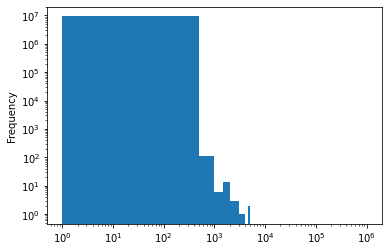

In [3]:
count_df["HOW_MANY"].plot(kind="hist",logx=True,logy=True,bins=2000)

As may be expected, the vast majority of feeders have very few counts, while some observations have hundreds, or possibly thousands of counts.  There is a single observation of 1E6 counts, but I suspect this value is in error.  Out of over 9 million observations, less than 5,000 have more than 100 counts of a given species.  

In [4]:
outliers = count_df["HOW_MANY"] > 100
np.count_nonzero(outliers)

4842

(0.0, 20.0)

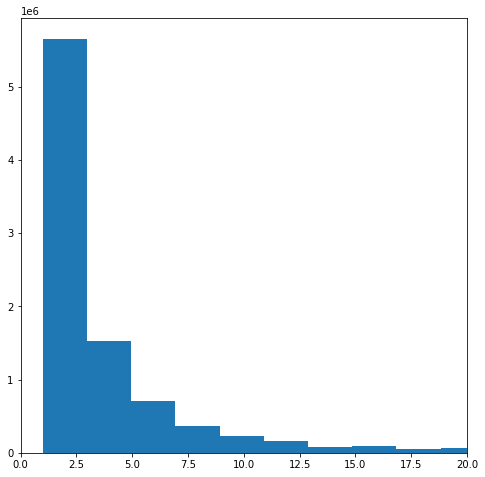

In [5]:
# a trimmed and zoomed histogram gives a better feel for the distribution to fit
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
bins,edges,_ = ax.hist(count_df["HOW_MANY"][np.invert(outliers)],bins=50)
ax.set_xlim(0,20)

The figure above shows a histogram of observed counts "zoomed" in to less than 20 counts.  I suspect that distributions such as gamma(k=1), a scaled chi2, or Weibull distribution may be suited to fitting this type of histogram where the probability density is highly concentrated at very low values and falls of rapidly.

In [6]:
bins,edges = np.histogram(count_df["HOW_MANY"][count_df["HOW_MANY"] <=20],bins=20)
centers = (edges[0:-1] + edges[1::]) / 2.0
bins = bins / np.nansum(bins)

### Question 1, part 2: distribution fitting / parameter estimation  

A quick look at scipy and Wikipedia suggests the distributions below may be worth a try.  I've removed some that gave fitting/convergence problems.  NB: in the interests of speed, I've chosen to fit the **histogram** of observed counts rather than the count data themselves.  The distribution fitting routine in scipy will output an MLE estimate of distribution parameters using all 9+ million datapoints.  While thorough, this approach is entirely too time consuming for the needs of the question asked.  Fitting a sample of the data would speed the process up, but risks introducing bias if sampling is not systematic.  Instead, I'm using a quasi-Newton approach to fit only 20 histogram centers and values along with a non regularized least-squares target function based on the PDF for each distribution.

For each distribution, an RMSD is calculated as well as test statistic and p-value from a Kolmogorov-Smirnov (KS) test.  For many of these distributions, the KS statistic was ~1.0 (suggesting the distribution fits very well) while RMSD values showed more variation.  Thus, I've picked the "best" distribution based on minimal RMSD.

In [7]:
distributions = ['beta','gamma','betaprime', 'burr', 'burr12', 
                 'exponweib', 'f', 'fisk', 'foldcauchy', 'halfcauchy', 
                 'invgamma', 'invweibull', 'johnsonsu', 'levy', 'loglaplace', 
                 'lognorm', 'mielke', 'ncf', 'nct', 'powerlognorm']

In [8]:
def fit_dist_by_hist(dist_name,bins,centers):
    distobj = getattr(stats,dist_name)
    shapes = distobj.shapes
    if shapes is not None:
        params =  list(name.strip() for name in shapes.split(","))
    else:
        params = []
    # establish a target function for the minimizer
    target = lambda par: np.nanmean((distobj.pdf(centers,*par) - bins)**2)
    init = list(1.0 for i in range(len(params) + 2))
    # use BFGS which can use numerical gradient/Hessian terms.
    fit = optimize.minimize(target,init,method="BFGS")
    return fit.x
    

In [9]:
def get_pred(dist_name,centers,params):
    # gets model values for plotting and RMSD calculation
    distobj = getattr(stats,dist_name)
    return distobj.pdf(centers,*params)

/tmp/ipykernel_30264/618157803.py:20: RuntimeWarning: divide by zero encountered in log
  best = (dist,kstest,-np.log(ksp),rmsd)
/tmp/ipykernel_30264/618157803.py:22: RuntimeWarning: divide by zero encountered in log
  results.append((dist,kstest,-np.log(ksp),rmsd))
/tmp/ipykernel_30264/618157803.py:20: RuntimeWarning: divide by zero encountered in log
  best = (dist,kstest,-np.log(ksp),rmsd)
/tmp/ipykernel_30264/618157803.py:22: RuntimeWarning: divide by zero encountered in log
  results.append((dist,kstest,-np.log(ksp),rmsd))
/tmp/ipykernel_30264/618157803.py:20: RuntimeWarning: divide by zero encountered in log
  best = (dist,kstest,-np.log(ksp),rmsd)
/tmp/ipykernel_30264/618157803.py:22: RuntimeWarning: divide by zero encountered in log
  results.append((dist,kstest,-np.log(ksp),rmsd))
/tmp/ipykernel_30264/618157803.py:22: RuntimeWarning: divide by zero encountered in log
  results.append((dist,kstest,-np.log(ksp),rmsd))
/tmp/ipykernel_30264/618157803.py:22: RuntimeWarning: divide 

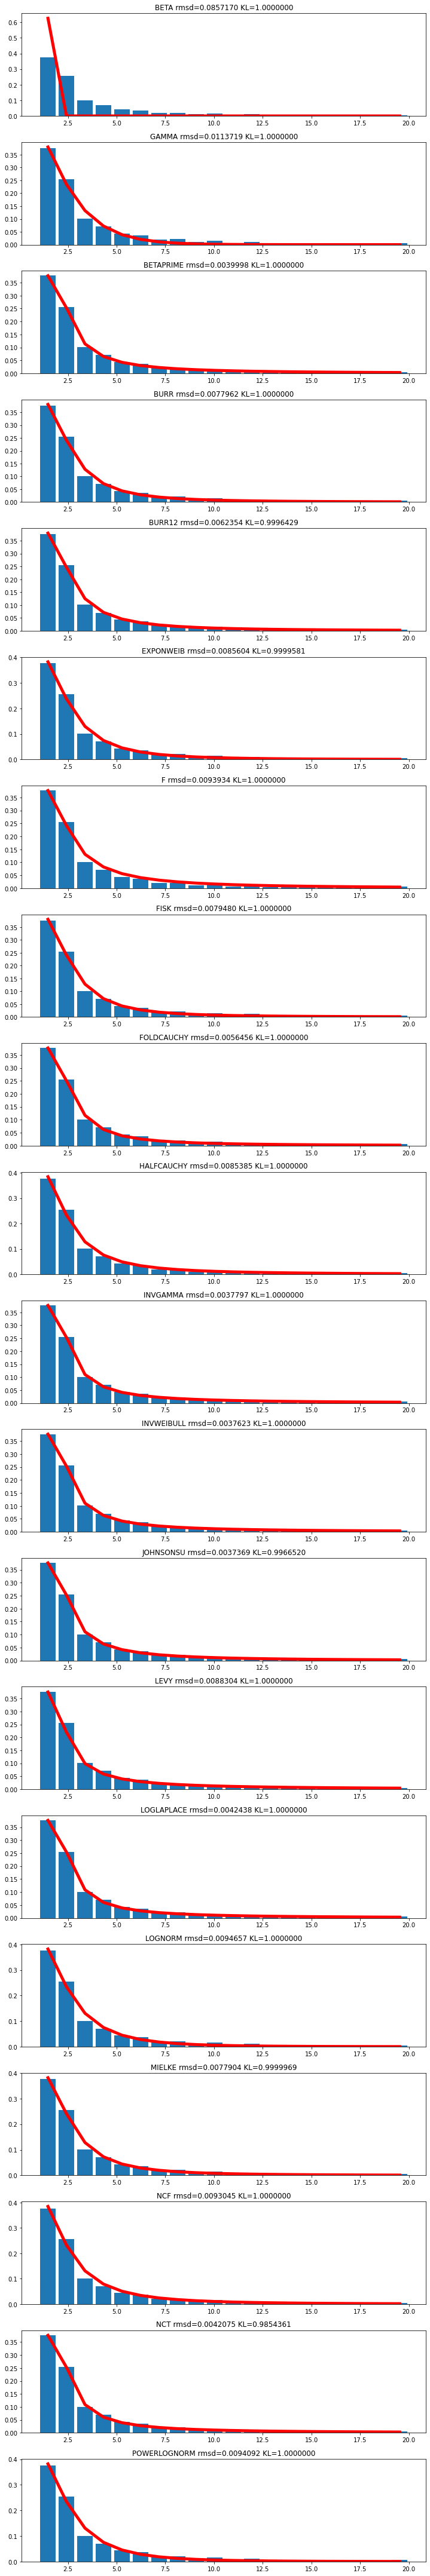

In [10]:
# iterate through each distribution, getting parameters and goodness-of-fit values
#%%capture --no-stdout
results = []
fig,ax = plt.subplots(nrows=len(distributions),ncols=1,figsize=(10,3*len(distributions)),tight_layout=True)
xplot = np.linspace(0,100,100)
best = None
best_rmsd = np.inf
for di,dist in enumerate(distributions):
    distobj = getattr(stats, dist)
    param = fit_dist_by_hist(dist,bins,centers)
    preds = get_pred(dist,centers,param)
    rmsd = np.sqrt(np.nanmean(np.multiply((bins - preds),(bins - preds))))
    # KL test statistic and p-value
    kstest,ksp = stats.kstest(bins, dist, args=param)
    ax[di].plot(centers,preds,color='red',linewidth=5)
    ax[di].bar(centers,bins)
    title = "{} rmsd={:8.7f} KL={:8.7f}".format(dist.upper(),rmsd,kstest)
    ax[di].set_title(title)
    if rmsd < best_rmsd:
        best = (dist,kstest,-np.log(ksp),rmsd)
        best_rmsd = rmsd
    results.append((dist,kstest,-np.log(ksp),rmsd))


In [11]:
print("The best distribution fit by RMSD was '{}' with RMSD={:8.7f}".format(best[0],best[-1]))

The best distribution fit by RMSD was 'johnsonsu' with RMSD=0.0037369


#### Question 1 -- summary:  
At a glance, all but the 1st distribution (beta) fit the observed histogram quite well.  However, by RMSD, the Johnson's-SU distribution provided the best fit.  This distribution is based on the Normal distribution, but allows for arbitrary skew and kurtosis.  Obviously, only the x>0 part of the distribution applies to the observed data (negative observations are impossible and zero observations not recorded).  Thus, I would not impart any "meaning" to the parameters of the fit distribution, but simply state that distribution of observed count frequencies is modelled quite well by this distribution.

## Question 2) Identify species of birds most associated with sites described as "woods".  

To address this question, data from the "sites" table that describes local ecology/environment will have to be joined to the "feeding" table.  Much of the data in the "sites" table is one-hot encoded values for various habitat descriptors.  For example, the columns "yard_type_woods", "hab_dcid_woods", "hab_evgr_woods", "hab_mixed_woods", and "hab_young_woods" all indicate some type of "woods" applies to the location identified.  There are similar columns for fresh/salt water, desert, shrubs, etc.  Other data include local wildlife (mostly domesticated) and feeder specifics out-of-scope to the question at hand.  Thus, I've explored treating columns indicating "woods" vs those indicating a local environment other than "woods".  

To probe the question, I've attempted two approaches:
1) Calculate how often each species is associated with a woods-related descriptor.  First, treat all woods related columns as indicative of "woods" and those in the cell below defined as "non_woods" (e.g. hab_fresh_water" as indicative of non-woods).  A given site may, in fact, be both if any of the the constituent boolean values are true.  With this woods/non-woods dichotomy in place, I've tablulated the fraction of observations for each species associated with "woods".  
2) By location type -- classify each location as strictly woods, strictly non-woods, or mixed then see which species were observed in locations identified as strictly woods.  

Technical note:
For the data queries needed, the SQL query mechanism of Pandas consumes too much memory to be useful.  I think Pandas interfaces to SQAlchemy and stores multiple copies of each query in memory.  Whatever the cause, when attempting to query the sqlite database via Pandas, the notebook repeatedly crashed with OOM errors.  Thus, I've elected to store the query directly in a structured numpy array which involves createding an array of fixed size and datatype and populating this array directly through the sqlite3 cursor.

In [12]:
sql ="""
SELECT {} FROM feeding INNER JOIN sites ON feeding.LOC_ID=sites.loc_id;
"""  

In [13]:
cur = con.cursor()
# list out columns for use in formatted SQL query
col_names = ["loc_id","species","count","woods_yard","hab_dwoods","hab_ewoods","hab_mwoods","hab_ywoods","non_woods"]
non_woods = ["hab_orchard","hab_park","hab_water_fresh","hab_water_salt","hab_residential","hab_industrial",
             "hab_agricultural","hab_desert_scrub","hab_swamp","hab_marsh"]
# using unsigned integers to keep memory requirements minimized
col_fmts = ["U8","U6",np.int64,np.uint16,np.uint16,np.uint16,np.uint16,np.uint16,np.uint32]
# we need to know the size to create a static numpy array
nrows = cur.execute(sql.format("COUNT(*)")).fetchone()[0]
array_dtype = np.dtype(list(zip(col_names,col_fmts)))
# the "+0" query instructions convert null values values that numpy will convert to unsigned integers
fetch_list = ["feeding.LOC_ID",
              "feeding.SPECIES_CODE",
              "ifnull(feeding.HOW_MANY,0)+0",
              "ifnull(sites.yard_type_woods,0)+0",
              "ifnull(sites.hab_dcid_woods,0)+0",
              "ifnull(sites.hab_evgr_woods,0)+0", 
              "ifnull(sites.hab_mixed_woods,0)+0",
              "ifnull(sites.hab_young_woods,0)+0",
              "ifnull({},0) AS non_woods".format("+".join(non_woods))]
array = np.fromiter(cur.execute(sql.format(",".join(fetch_list))),dtype=array_dtype,count=nrows)


In [14]:
# good idea to save in case we crash at this point
np.save("bird_env_data.npy",array)

In [15]:
# some useful info
unique_sp = set(array["species"])
unique_loc = set(array["loc_id"])
print("There are {} unique bird species and {} unique locations observed".format(len(unique_sp),len(unique_loc)))

There are 640 unique bird species and 25747 unique locations observed


In [16]:
# next, calculate the fraction of observations associated with "woods"
# done iteratively for each species.  A bit slow, but not unreasonably so.
woods = np.logical_or.reduce(list(array[col] for col in ["hab_dwoods","hab_ewoods","hab_mwoods","hab_ywoods"]))
non_woods = array["non_woods"] > 0
woods_count = array["count"] * woods
non_woods_count = array["count"] * non_woods
counts_by_species = {}
for si,sp in enumerate(sorted(list(unique_sp))):
    sel = array["species"] == sp
    n_obs = np.nansum(array["count"][sel])
    woods_sum = np.nansum(woods_count[sel])
    non_woods_sum = np.nansum(non_woods_count[sel])
    counts_by_species[sp] = (n_obs,woods_sum,non_woods_sum)
    if si % 100 == 0:
        print("Completed run {}, species={}".format(si,sp))



Completed run 0, species=abetow
Completed run 100, species=bucnig
Completed run 200, species=fieldf
Completed run 300, species=laufal
Completed run 400, species=pilwoo
Completed run 500, species=sonspa
Completed run 600, species=x00423


In [17]:
woods_ratios = {}
for sp,(n_obs,wc,nwc) in counts_by_species.items():
    total = wc + nwc
    if total > 0:
        woods_ratios[sp] = wc / total

Text(0.5, 1.0, 'Ratio woods:non_woods habitats for 640 species')

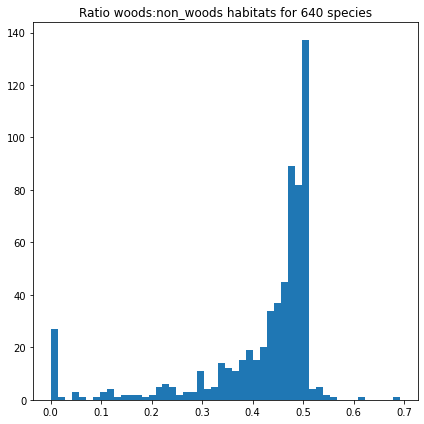

In [18]:
fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(6,6),tight_layout=True)
axis.hist(list(woods_ratios.values()),bins=50)
axis.set_title("Ratio woods:non_woods habitats for 640 species")

A histogram of fraction of count-weighted observations associated with "woods" for each species.  If a location is mixed (both woods and non-woods), its observation count will be included in the total of both woods and non-woods which are ultimately used to calculate the "woods associated" fraction.  Only a few species have fraction appreciably above 0.5.  At this point, a closer look at the data is in order to see if this approach has any merit.

In [19]:
as_pairs = sorted(list((k,v) for k,v in woods_ratios.items()),key=lambda t:t[1],reverse=True)
culled = list(t for t in as_pairs if counts_by_species[t[0]][0] > 1000)
for sp,ratio in as_pairs[0:5]:
    print("Most 'woods associated' species {} woods ratio = {:4.3f} counts = {}".format(sp,ratio,counts_by_species[sp][0]))
for sp,ratio in as_pairs[-5::]:
    print("Least 'woods associated' species {} woods ratio = {:4.3f} counts = {}".format(sp,ratio,counts_by_species[sp][0]))

Most 'woods associated' species chicka woods ratio = 0.692 counts = 19
Most 'woods associated' species rucspa woods ratio = 0.617 counts = 6649
Most 'woods associated' species yelgro woods ratio = 0.556 counts = 6
Most 'woods associated' species yecpar woods ratio = 0.551 counts = 301
Most 'woods associated' species y00338 woods ratio = 0.547 counts = 1665
Least 'woods associated' species whepar woods ratio = 0.000 counts = 36
Least 'woods associated' species whfibi woods ratio = 0.000 counts = 22
Least 'woods associated' species y00323 woods ratio = 0.000 counts = 12
Least 'woods associated' species y00330 woods ratio = 0.000 counts = 18
Least 'woods associated' species yehpar woods ratio = 0.000 counts = 24


Output for top/bottom 5 values of woods-associated fraction along with observation counts.  To sanity check these data, I've gathered habitat information from various sources such as "animaldiversity.org","birdsoftheworld.org",and wikipedia.  Quoted text below comes from these sources.

### quick info on each of the species noted above

1) The most "woods associated" is "chika", the code for "chickadee sp.", technically a "spuh" (a term-of-art in the bird watching world referring to a group of closely related species).  Very common bird and the grouping of many species of chickadee into a single clade may make this identification ambiguous.  
2) Rucspa = rufous-collared sparrow.  "...from grasslands in eastern South America to high plateaus in the Andes mountain range in the west, including rural and urban habitats...found in forested areas when there is a roadway, river, or a clearing to create an opening in the canopy"  
3) yelgro = Ph. chrysopoplus aurantiacus (Guatemalan Yellow Grosbeak).  "Tropical deciduous and semi-deciduous forest, well-wooded watercourses, scrubby woodland and thorn-forest; race aurantiacus also in clearings in humid evergreen forest."   
4) yecpar = yellow-chevroned parakeet native to the Amazon rainforest  
5) y00338 = house finch.  "...open desert and desert grassland, chaparral, oak savannah, riparian areas, and open coniferous forests of the western United States, their native range."  
6) One of the least woods-associated species is yehpar = yellow-headed amazon (parrot) "It inhabits dense thorn-forest, savanna, tall deciduous forest and humid riverine woodland"  
7) y00330 - bendire's thrasher, common in desert habitats  
8) y002323 - gilder flicker, birdsoftheworld.org: "The Gilded Flicker is closely associated with the Sonoran Desert ecosystem in the southwestern United States"  
9) whfibi = white-faced-ibis -- waterfoul / prefers wetlands  
10) whepar = white-eyed parakeet -- many habitats, including mangroves, swamps, and scrub.  






Some of these findings make sense.  In particular 3, 4, and 5 exhibit high woods-associated fractions and their habitat descriptions are consistent with these species being, in fact, associated with woody habitats.  Similarly, 7, 8, 9, and 10 were never observed in woods-associated locations and their habitat descriptions seem to confirm that their habitats are, indeed, not woods-associated (desert, desert, water, mangroves).  So, this approach seems on the right track, but I suspect some issues are at play here:  
1) sampling bias -- observation data comes from bird feeders which may be closer to developed areas and thus may not effectively sample birds outside of developed areas.  To wit, there are no observations for any species of duck in the data.  Perhaps ducks do not appear at feeders (or most waterfoul for that matter).  
2) ambiguous identification of habitat (label noise)  -- simply grouping habitats with "woods" in their descriptors vs. others may obscure true differences in habitat preference.  
3) Sample size -- observation counts vary considerably among all species and, for species with comparitively fewer observations, a few spurrious observations in a given habitat may give the false impression that that species truely prefers the habitat in which is was observed.  

To explore this last point, I looked again at the woods-associated fraction for species with only 1000 observations.  However, the number of observations is not the number of locations.  Thus, it's possible that, even though a given species was observed at least 1000 times, these observations could have been made at a small number of locations.  

In [20]:
for sp,ratio in culled[0:5]:
    print("Most 'woods associated' species {} woods ratio = {:4.3f} counts = {}".format(sp,ratio,counts_by_species[sp][0]))
for sp,ratio in culled[-5::]:
    print("Least 'woods associated' species {} woods ratio = {:4.3f} counts = {}".format(sp,ratio,counts_by_species[sp][0]))

Most 'woods associated' species rucspa woods ratio = 0.617 counts = 6649
Most 'woods associated' species y00338 woods ratio = 0.547 counts = 1665
Most 'woods associated' species rosfin woods ratio = 0.532 counts = 175280
Most 'woods associated' species mouqua woods ratio = 0.525 counts = 2551
Most 'woods associated' species larspa woods ratio = 0.525 counts = 31145
Least 'woods associated' species abetow woods ratio = 0.099 counts = 51492
Least 'woods associated' species chukar woods ratio = 0.055 counts = 8060
Least 'woods associated' species gilfli woods ratio = 0.048 counts = 4294
Least 'woods associated' species bucpar woods ratio = 0.006 counts = 2303
Least 'woods associated' species peflov woods ratio = 0.004 counts = 26894


These species appeared which considering only species observed at least 1000 times:

```
rosfin = (spuh) finch, very many habitats  
mouqua = mountain quail, mountains of western north america  
lorspa = lark sparrow:  "...prairies, savannah, mesas, farmlands, open woodland"  
peflov = rosy-faced lovebird:  native to Africa?  
gilfli = glided flicker, woodpecker  
abetow = alber's towhee: "dense brush and woodlands along Sonoran Desert rivers and streams"  
```
Some of these observations are suspicious.  For example, the "gilfli" is a woodpecker but would be considered non-woods-associated by this analysis.  I'm no bird expert, but I would think that a woodpecker prefers woods.  I have no clear explanation for why the rosy-faced lovebirds were observed in the southwest as they are considered native to Africa.  Thus, while reasonable, I suspect this approach suffers from the issues noted above. 

To approach the question from another point-of-view, I've classified each location available as woods, non-woods, or mixed and have then looked for species strongly associated with woods locations.  The breakdown between woods/non-woods is done through an SQL query that sums the one-hot encoded values for habitats clearly associated with woods ("woods_hab" below) and those markedly distinct from woods ("nwoods_hab").  Woods habitats are those with a True value for any woods habitat, etc.



In [21]:
woods_hab = ["hab_dcid_woods","hab_evgr_woods","hab_mixed_woods","hab_young_woods"]
nwoods_hab = ["hab_water_fresh","hab_water_salt","hab_desert_scrub","hab_swamp","hab_marsh"]
sql = """
WITH selector AS (SELECT DISTINCT loc_id,{} AS woods,{} AS non_woods FROM sites WHERE woods{} AND non_woods{})
    SELECT {},loc_id,species_code,SUM(how_many) FROM feeding WHERE loc_id IN (SELECT loc_id FROM selector) 
    GROUP BY species_code
"""  
woods_data = cur.execute(sql.format(",".join(woods_hab),"+".join(nwoods_hab),">0","=0",1)).fetchall()
nwoods_data = cur.execute(sql.format(",".join(woods_hab),"+".join(nwoods_hab),"=0",">0",0)).fetchall()
                         

In [22]:
nwoods_data[0:10]

[(0, 'L10106521', 'abetow', 4408),
 (0, 'L1005097', 'accipi', 849),
 (0, 'L10040484', 'acowoo', 6828),
 (0, 'L1889829', 'afcdov1', 24),
 (0, 'L31331', 'agwtea1', 1),
 (0, 'L10074000', 'allhum', 5355),
 (0, 'L10183326', 'altori', 14),
 (0, 'L1023048', 'ambduc', 4639),
 (0, 'L10148585', 'amebit', 1),
 (0, 'L1027212', 'amecoo', 568)]

In [23]:
as_pdf = pd.DataFrame(woods_data + nwoods_data,columns=["is_woods","loc_id","species","count"])

In [24]:
as_pdf.head()

,is_woods,loc_id,species,count
0,1,L130714,abetow,1756
1,1,L10225720,accipi,273
2,1,L10114355,acowoo,3374
3,1,L22924,afcdov1,19
4,1,L31331,agwtea1,1


In [25]:
sel_woods = as_pdf["is_woods"] == 1
sel_nwoods = as_pdf["is_woods"] == 0
found_in_both = set(as_pdf["species"][sel_woods]) & set(as_pdf["species"][sel_nwoods])
only_woods = set(as_pdf["species"][sel_woods]) - set(as_pdf["species"][sel_nwoods])
only_nwoods = set(as_pdf["species"][sel_nwoods]) - set(as_pdf["species"][sel_woods])

In [26]:
print("Habitat grouping: {} species found in both woods and non_woods".format(len(found_in_both)))
print("Habitat grouping: {} species found in only woods".format(len(only_woods)))
print("Habitat grouping: {} species found in only non_woods".format(len(only_nwoods)))

Habitat grouping: 486 species found in both woods and non_woods
Habitat grouping: 65 species found in only woods
Habitat grouping: 124 species found in only non_woods


In [27]:
only_woods_ranked = list((sp,np.nansum(as_pdf["count"][as_pdf["species"] == sp])) for sp in only_woods)
only_woods_ranked.sort(key=lambda t:t[1],reverse=True)
for sp,count in only_woods_ranked[0:5]:
    print("Species {} observed {} times in only woods associated habitats".format(sp,count))
only_nwoods_ranked = list((sp,np.nansum(as_pdf["count"][as_pdf["species"] == sp])) for sp in only_nwoods)
only_nwoods_ranked.sort(key=lambda t:t[1],reverse=True)
for sp,count in only_nwoods_ranked[0:5]:
    print("Species {} observed {} times in only non-woods associated habitats".format(sp,count))    
                       

Species yewcac1 observed 705 times in only woods associated habitats
Species stbori observed 393 times in only woods associated habitats
Species rubcha1 observed 206 times in only woods associated habitats
Species grbani observed 151 times in only woods associated habitats
Species grasal1 observed 125 times in only woods associated habitats
Species y00475 observed 2016 times in only non-woods associated habitats
Species bkhpar observed 867 times in only non-woods associated habitats
Species rudduc observed 299 times in only non-woods associated habitats
Species amwpel observed 250 times in only non-woods associated habitats
Species bucpar observed 213 times in only non-woods associated habitats


#### Question 2 -- looking for differences by location  
Below is a habitat description for a few examples of the above observations.
The first and last are sensible.  The cacique is highly woods-associated by this analysis and its habitat is consistent with this association.  Similarly, the Cood is a strongly non-woods-associated species and is described as a waterfoul.  Thus, I believe this approach is more on the right track or, at least, offers suggestions for woods-associated species more supported by the data at hand.

```
yewcac1 = Yellow-winged Cacique "Favors deciduous forest and edges, plantations, and hedges with tall trees"
bucpar = American Cood:  "freshwater lakes and ponds of the northern United States..."
stbori = streak-backed oriole "Dry tropical forests, from northwestern Mexico to Costa Rica"
```

#### Question 2 -- summary:  
This question has proved challenging.  I did not find any obvious "smoking gun" of species obviously associated with woods habitats.  The aforementioned issues with the data (sample bias, ambiguous habitat labels, and skew caused by small observation sizes at some locations) certainly present difficulties in clearly identifying preferred habitat for a given species.  Nonetheless, I believe the analyses above point to certain species (elg. Cacique, Sparrow, Grosbeak) as being woods-associated.

### Question 3 Generate an interesting visualization from the location data provided.  
How do the locations for the 10 most commonly observed species in the data set compare in terms of location?  To address this question, I've binned the location data data for these species and plotted on a zoomed map of North America.

In [28]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


In [29]:
most_common = cur.execute("SELECT SPECIES_CODE,COUNT(HOW_MANY) AS count FROM feeding GROUP BY SPECIES_CODE ORDER BY count DESC LIMIT 10").fetchall()

In [30]:
most_common_sp = list(t[0] for t in most_common)

In [31]:
sql = """
SELECT LATITUDE,LONGITUDE,HOW_MANY,SPECIES_CODE FROM feeding WHERE SPECIES_CODE in ({})
"""
common = cur.execute(sql.format(",".join(list('"{}"'.format(sp) for sp in most_common_sp)))).fetchall()

In [32]:
# Pandas binning very helpful here.
geo_df = pd.DataFrame(common, columns=["lat","lon","count","species"])
geo_df = geo_df[geo_df["lon"] < 0]
geo_df["lat_bin"],lat_bins = pd.cut(geo_df["lat"],200,labels=False,retbins=True)
geo_df["lon_bin"],lon_bins = pd.cut(geo_df["lon"],200,labels=False,retbins=True)
geo_df.head()

,lat,lon,count,species,lat_bin,lon_bin
0,28.04297,-82.622681,1,dowwoo,36,147
1,28.04297,-82.622681,1,blujay,36,147
2,28.04297,-82.622681,5,norcar,36,147
3,28.04297,-82.622681,2,tuftit,36,147
4,28.04297,-82.622681,3,moudov,36,147


In [33]:
lat_centers = (lat_bins[1::] + lat_bins[:-1]) / 2.0
lon_centers = (lon_bins[1::] + lon_bins[:-1]) / 2.0

In [34]:
geo_df["lat"] = lat_centers[geo_df["lat_bin"]]
geo_df["lon"] = lon_centers[geo_df["lon_bin"]]
geo_df = geo_df.groupby(["lat","lon","species"]).sum()
geo_df = geo_df.reset_index()


In [35]:
# recover common names for plotting
# the species.csv was output from the excel document described at the top of this notebook
species_info = pd.read_csv("species.csv",header=0)
name_map = {sp:name for sp,name in list(zip(species_info["SPECIES_CODE"],species_info["PRIMARY_COM_NAME"]))}

Text(0.5, 1.0, 'Binned location data for 10 most common bird species')

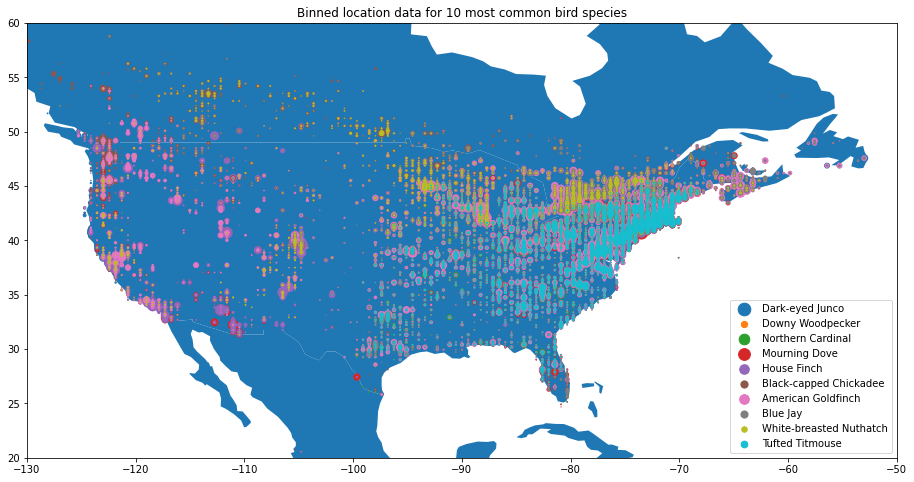

In [36]:
geo_data = []
for sp in most_common_sp:
    sel = geo_df["species"] == sp
    data=geo_df[sel]
    seli = list(np.nonzero(sel.to_numpy())[0])
    geo_points = list(Point(xy) for xy in zip(data['lon'], data['lat']))
    gdf = GeoDataFrame(data, geometry=geo_points)
    geo_data.append((gdf,seli))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_ax = world[world.continent == "North America"].plot(figsize=(16, 8))
for index,(gdf,seli) in enumerate(geo_data):
    sizes = geo_df["count"][seli] / 100.0
    name = name_map[most_common_sp[index]]
    gdf.plot(ax=world_ax,marker='o', markersize=sizes,label=name)
world_ax.set_xlim(-130,-50)
world_ax.set_ylim(20,60)
world_ax.legend()
world_ax.set_title("Binned location data for 10 most common bird species")


#### Question 4 -- visualization  
Location data for all species were binned and the sum of each species in a given coordinate bin was plotted as a round circle colored as described in the legend whose size represents the tabulated sum.  The plot shows clear location differences among species.  For example, the Nuthatch (yellow) is clearly observed more frequently in more northern regions while Junco observations are almost entirely confied to the eastern US.  Also of interest, observations of the Mourning Dove (red) sppear confined to a large number of observations at a few unique sites.  These birds are widespread and very common across much of North America.  Thus, I suspect that they frequent feeders less than other birds noted here (or only a specific type of feeder, which was not considered).

#### Final thought  
The Mourning Dove example highlights an important consideration when making use of this dataset.  Specifically, the dataset is for observations noted at feeding sites which may not sample birds systematically.  Thus, these data may not be best for gaining insights into how bird species are distributed.  However, the project that generated this dataset has similar datasets dating back to 1988 (the data used here were an aggregate of 2016-2020) and a longitudinal study of all available on a site-by-site basis could provide useful insights as to how the distributions bird populations have changed over time.  Thus, while a given time-frame of these data may not give a full picture of what birds can be found where, a study of observations over time (provided reasonable consistency of feeder locations) may reveal how preferred habitats or migratory patterns have shifted over time. 